In [1]:
import numpy as np
# from scipy.optimize import curve_fit
import sys
import matplotlib.pyplot as plt

import iminuit
print("iminuit version:", iminuit.__version__)
from iminuit import Minuit
from iminuit.cost import LeastSquares
import inspect

iminuit version: 1.5.4


In [2]:
## PARAMETERS
# Computing B1 LS
# B1 is stationary
# B2 is scanning

# definition of LS: BPM_length * LS = true_length

params = {
    # "Nominal_LS":1.05,
    "Nominal_LS_B1":1.0,
    # "Nominal_LS_B1":0.995,
    # "Doros_LS_B1":1.05,
    # "Doros_LS_B1":1.0,
    "Doros_LS_B1":0.995,
    # "Arc_LS_B1":1.05,
    "Arc_LS_B1":1.0,
    # "Arc_LS_B1":0.995,
    "Nominal_LS_B2":1.0,
    # "Nominal_LS_B2":0.995,
    # "Doros_LS_B2":1.05,
    "Doros_LS_B2":0.8,
    # "Doros_LS_B2":0.995,
    # "Arc_LS_B2":1.05,
    "Arc_LS_B2":1.0,
    # "Arc_LS_B2":0.995,
    "Sigma_B1":90, #micron
    "Sigma_B2":90, #micron
    "nominal_step_size_B1": 130, #micron
    "nominal_step_size_B2": 130, #micron
    "commulative_OD":False,
    "OD_B1":[
        10,0,0,
        0,0,0,
        0,0,0,
        0,0,0,
        0,0,0,
    ],
    "OD_B2":[
        0,0,0,
        0,0,0,
        0,0,0,
        0,0,0,
        0,0,0,
    ],
    "Doros_noise_sigma":0, # micron
    "Arc_noise_sigma":0, # micron
    "rate_runcertainty_at_head_on":0.005, 
    "beamspot_position_uncertainty":1, #micron
    # "pos_strategy":"doros, middle point",
    "pos_strategy":"doros, avg point",
}

In [3]:
# utility fitting function using minuit for better error propagation
def curve_fit(f, x, y, sigma=None, p0=None, p0_lim=None):

    if sigma is None:
        sigma = np.ones_like(y)

    init_params = {}
    if not p0 is None:
        for i, n in enumerate(inspect.getfullargspec(f)[0][1:]):
            init_params[n]=p0[i]
    if not p0_lim is None:
        for i, n in enumerate(inspect.getfullargspec(f)[0][1:]):
            init_params["limit_"+n]=p0_lim[i]

    least_squares = LeastSquares(x, y, sigma, f)

    m = Minuit(least_squares, **init_params)

    m.migrad()    
    try:
        cov = np.array(m.matrix())
    except:
        try:
            m.hesse()
            cov = np.array(m.matrix())
        except:
            m.hesse()
            cov = np.array(m.matrix())
        

    return m.np_values(), cov



# test
def lin(x,a,b):
        return a*x+b
popt_lin, pcov_lin = curve_fit(lin, range(4), [0,1.1,1.9,3], sigma=[1,1,1,1], p0=[1, 0])
print(popt_lin)
print(pcov_lin)

[0.98 0.03]
[[ 0.2 -0.3]
 [-0.3  0.7]]


Text(0, 0.5, 'Beam position')

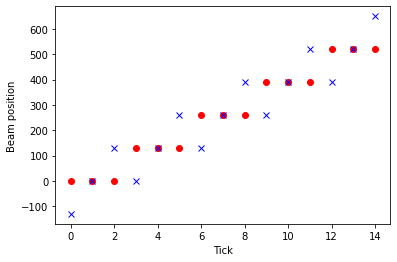

In [4]:
## nominal beampositions

nominal_B1_positions = np.repeat((np.arange(5)*params["nominal_step_size_B1"]),3)
scan_pattern = np.tile([-params["nominal_step_size_B2"], 0, params["nominal_step_size_B2"]], 5)
nominal_B2_positions = nominal_B1_positions + scan_pattern

plt.plot(range(15), nominal_B1_positions, "or")
plt.plot(range(15), nominal_B2_positions, "xb")
plt.xlabel('Tick')
plt.ylabel('Beam position')

In [5]:
## OD and BPM
if params["cumulative_OD"]:
    true_B1_positions = nominal_B1_positions * params["Nominal_LS_B1"] + np.cumsum(params["OD_B1"])
    true_B2_positions = nominal_B2_positions * params["Nominal_LS_B2"] + np.cumsum(params["OD_B2"])
else:
    true_B1_positions = nominal_B1_positions * params["Nominal_LS_B1"] + params["OD_B1"]
    true_B2_positions = nominal_B2_positions * params["Nominal_LS_B2"] + params["OD_B2"]

doros_B1_positions = true_B1_positions / params["Doros_LS_B1"] + np.random.normal(size=true_B1_positions.shape) * params["Doros_noise_sigma"] 
doros_B2_positions = true_B2_positions / params["Doros_LS_B2"] + np.random.normal(size=true_B2_positions.shape) * params["Doros_noise_sigma"]

arc_B1_positions = true_B1_positions / params["Arc_LS_B1"] + np.random.normal(size=true_B1_positions.shape) * params["Arc_noise_sigma"]
arc_B2_positions = true_B2_positions / params["Arc_LS_B2"] + np.random.normal(size=true_B2_positions.shape) * params["Arc_noise_sigma"]

avg_B1_positions = (doros_B1_positions + arc_B1_positions)/2
avg_B2_positions = (doros_B2_positions + arc_B2_positions)/2


plt.plot(range(15), doros_B1_positions-nominal_B1_positions+1, "o-r")
plt.plot(range(15), arc_B1_positions-nominal_B1_positions-1, "o-b")
plt.plot(range(15), avg_B1_positions-nominal_B1_positions, "o-y")
plt.xlabel('Tick')
plt.ylabel('BPM - nominal')
plt.show()

plt.plot(range(15), doros_B2_positions-nominal_B2_positions+1, "o-r")
plt.plot(range(15), arc_B2_positions-nominal_B2_positions-1, "o-b")
plt.plot(range(15), avg_B2_positions-nominal_B2_positions, "o-y")
plt.xlabel('Tick')
plt.ylabel('BPM - nominal')
plt.show()


KeyError: 'cumulative_OD'

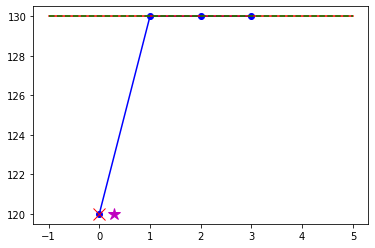

[ 10. 130. 260. 390. 520.]


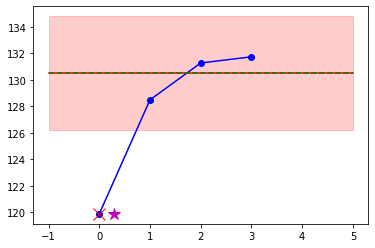

[ 12.64588421 132.01112499 260.         390.77192887 522.01112499]


In [ ]:
def avg_stepsize_corr_b1(positions, nominal_positions, b1_strategy = "m", outliers=0, plot=False):

    nominal_step_size = nominal_positions[3] - nominal_positions[0]

    if b1_strategy == "c":
        pos_c   = positions[1::3]        
    elif b1_strategy == "m":
        pos_c = np.array( [ np.mean(positions[3*i:3*i+3]) for i in range(5)] ) 
    diffs =  np.diff( pos_c )

    if plot:
        plt.plot(range(len(diffs)), diffs, "o-b")

    if outliers == 0:
        avg_step_size = np.mean( diffs )
    else:
        excluded_indices = []

        diffs1  = diffs[:]
        for i in range(outliers):
            avg     = np.mean( diffs1 )
            i_extremum = np.argmax(np.abs(diffs1-avg))
            if np.abs(diffs1[i_extremum] - avg)<0.01:
                break
            excluded_indices.append( np.where(np.isclose(diffs, diffs1[i_extremum]))[0][0] )
            diffs1 = diffs1[ np.arange(len(diffs1)) != i_extremum ]
        avg = np.mean(diffs1)
        std = np.std(diffs1)
        lim = 3*std
        diffs2 = diffs[ np.abs( diffs-avg )<=lim ]
        avg_step_size = np.mean(diffs2)

        if plot:
            plt.plot(excluded_indices, diffs[np.array(excluded_indices)], "xr", markersize=12)
            plt.plot([-1,5], [avg, avg], "-", color="red")
            plt.fill_between([-1,5], [avg-lim, avg-lim], [avg+lim, avg+lim], color="red", alpha=0.2)
            plt.plot(np.arange(len(diffs))[ np.abs( diffs-avg )>lim ]+0.3, diffs[ np.abs( diffs-avg )>lim ], "*m", markersize=12)
    
    if plot:
        plt.plot([-1,5], [avg_step_size, avg_step_size], "--g")
        plt.show()

            
    od_estimates = diffs - avg_step_size
    new_stepsizes = od_estimates + nominal_step_size
    new_positions = np.concatenate(([0], np.cumsum(new_stepsizes)))
    # take the middle point as reference
    new_positions = new_positions - new_positions[2] + nominal_positions[7]

    return new_positions

# testing
test_positions = np.repeat(np.arange(5),3)*130.0
test_positions[0:2]+=10
print(avg_stepsize_corr_b1(test_positions, nominal_B1_positions, b1_strategy = "c", outliers=1, plot=True))

test_positions = np.repeat(np.arange(5),3)*130.0
test_positions+= np.random.normal(size=15)*10
print(avg_stepsize_corr_b1(test_positions, nominal_B1_positions, b1_strategy = "m", outliers=1, plot=True))

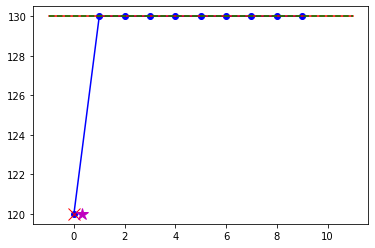

[-10.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
[120. 130. 130. 130. 130. 130. 130. 130. 130. 130.]
[-120.    0.  130.    0.  130.  260.  130.  260.  390.  260.  390.  520.
  390.  520.  650.]


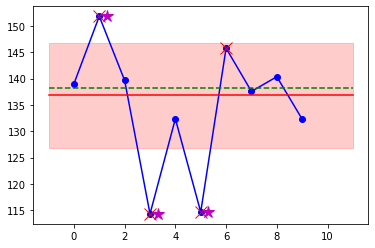

[  0.85937871  13.69232827   1.5089282  -23.82879547  -5.78253643
 -23.46507555   7.62499001  -0.58098305   2.21490146  -5.8446789 ]
[130.85937871 143.69232827 131.5089282  106.17120453 124.21746357
 106.53492445 137.62499001 129.41901695 132.21490146 124.1553211 ]
[-130.85937871    0.          143.69232827   -1.5089282   130.
  236.17120453  135.78253643  260.          366.53492445  252.37500999
  390.          519.41901695  387.78509854  520.          644.1553211 ]


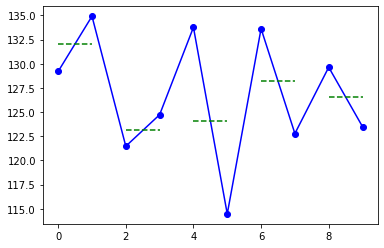

[-2.85442949  2.85442949 -1.63029122  1.63029122  9.64988152 -9.64988152
  5.42196862 -5.42196862  3.07517926 -3.07517926]
[127.14557051 132.85442949 128.36970878 131.63029122 139.64988152
 120.35011848 135.42196862 124.57803138 133.07517926 126.92482074]
[-127.14557051    0.          132.85442949    1.63029122  130.
  261.63029122  120.35011848  260.          380.35011848  254.57803138
  390.          514.57803138  386.92482074  520.          646.92482074]


In [ ]:
def avg_stepsize_corr_sep(positions, nominal_positions, steps_to_average=10, outliers=0, plot=False):

    nominal_step_size = nominal_positions[1] - nominal_positions[0]

    diffs = np.diff(positions)
    diffs = diffs[ (np.arange(len(diffs)) % 3) != 2]

    if plot:
        plt.plot(range(len(diffs)), diffs, "o-b")

    if steps_to_average == 10:
        if outliers == 0:
            avg_step_size = np.mean( diffs )
        else:
            # remove 4 outliers
            excluded_indices = []
            diffs1  =diffs[:]
            for i in range(outliers):
                avg  = np.mean( diffs1 )
                i_extremum = np.argmax(np.abs(diffs1-avg))
                if np.abs(diffs1[i_extremum] - avg)<0.01:
                    break
                excluded_indices.append( np.where(np.isclose(diffs, diffs1[i_extremum]))[0][0] )
                diffs1 = diffs1[ np.arange(len(diffs1)) != i_extremum ]
            avg = np.mean(diffs1)
            std = np.std(diffs1)
            lim = 3*std
            diffs2 = diffs[ np.abs( diffs-avg )<=lim ]
            avg_step_size = np.mean(diffs2)


            if plot:

                plt.plot(excluded_indices, diffs[np.array(excluded_indices)], "xr", markersize=12)
                plt.plot([-1,11], [avg, avg], "-", color="red")
                plt.fill_between([-1,11], [avg-lim, avg-lim], [avg+lim, avg+lim], color="red", alpha=0.2)
                plt.plot(np.arange(len(diffs))[ np.abs( diffs-avg )>lim ]+0.3, diffs[ np.abs( diffs-avg )>lim ], "*m", markersize=12)
                
        if plot:
            plt.plot([-1,11], [avg_step_size, avg_step_size], "--g")
            plt.show()

        od_estimates = diffs - avg_step_size
        new_stepsizes = od_estimates + nominal_step_size

    elif steps_to_average == 2:

        avg_step_sizes = np.repeat([ np.mean(diffs[2*i:2*i+2]) for i in range(5) ], 2)
        od_estimates = diffs - avg_step_sizes
        new_stepsizes = od_estimates + nominal_step_size

        if plot:
            for i in range(5):
                plt.plot(np.arange(len(avg_step_sizes))[2*i:2*i+2], avg_step_sizes[2*i:2*i+2], "--g")
            plt.show()

    # reference is always the middle point
    print(od_estimates)
    print(new_stepsizes)
    result = np.repeat(nominal_positions[1::3], 3)*1.0
    for i in range(len(result)):
        if i%3==0:
            result[i] -= new_stepsizes[i//3*2]
        elif i%3==2:
            result[i] += new_stepsizes[(i-2)//3*2+1]
    return result

test_positions = np.array(nominal_B2_positions)*1.0
test_positions[0]+=10
print(avg_stepsize_corr_sep(test_positions, nominal_B2_positions, steps_to_average=10, outliers=4, plot=True))

test_positions = np.array(nominal_B2_positions)*1.0
test_positions+= np.cumsum(np.random.normal(size=15)*10)
print(avg_stepsize_corr_sep(test_positions, nominal_B2_positions, steps_to_average=10, outliers=4, plot=True))

test_positions = np.array(nominal_B2_positions)*1.0
test_positions+= np.cumsum(np.random.normal(size=15)*10)
print(avg_stepsize_corr_sep(test_positions, nominal_B2_positions, steps_to_average=2, outliers=0, plot=True))

In [ ]:
## OD correction of nominal

# this part needs to compute the followings:
# analysis_B1_positions or analysis_separations
# analysis_B2_positions or analysis_separations
# analysis_B1_5positions

# maybe we don't need to do step size correction for the scanning beam at all! 
# after all this method should be only sensitive to the LS of B1!
# in fact, probably we should always just use avg for the scanning beam, as that is the safest and most accrate probably

# the miniscan deltas are from the bpm-s directly 

if params["pos_strategy"]=="nominal, middle point":
    analysis_separations   = nominal_B1_positions - nominal_B2_positions
    analysis_B1_5positions = nominal_B1_positions[1::3]
elif params["pos_strategy"]=="nominal, avg point":
    analysis_separations   = nominal_B1_positions - nominal_B2_positions
    analysis_B1_5positions = np.array([ np.mean(nominal_B1_positions[3*i:3*i+3]) for i in range(5)])
elif params["pos_strategy"]=="doros, middle point":
    analysis_separations   = doros_B1_positions - doros_B2_positions
    analysis_B1_5positions = doros_B1_positions[1::3]
elif params["pos_strategy"]=="doros, avg point":
    analysis_separations   = doros_B1_positions - doros_B2_positions
    analysis_B1_5positions = np.array([ np.mean(doros_B1_positions[3*i:3*i+3]) for i in range(5)])
#######################
elif params["pos_strategy"]=="doros, b1 stepsize, b2 stepsize 10, avg point":
    analysis_separations   = doros_B1_positions - doros_B2_positions
    analysis_separations   = avg_stepsize_corr_sep(analysis_separations, steps_to_average=10, outliers=0)
    analysis_B1_5positions = avg_stepsize_corr_b1(doros_B1_positions, nominal_B1_positions, b1_strategy = "m", outliers=0)
elif params["pos_strategy"]=="doros, b1 stepsize, b2 stepsize 2, avg point":
    analysis_separations   = doros_B1_positions - doros_B2_positions
    analysis_separations   = avg_stepsize_corr_sep(analysis_separations, steps_to_average=2, outliers=0)
    analysis_B1_5positions = avg_stepsize_corr_b1(doros_B1_positions, nominal_B1_positions, b1_strategy = "m", outliers=0)
elif params["pos_strategy"]=="doros, b1 stepsize, b2 stepsize 10 outlier4, avg point":
    analysis_separations   = doros_B1_positions - doros_B2_positions
    analysis_separations   = avg_stepsize_corr_sep(analysis_separations, steps_to_average=10, outliers=4)
    analysis_B1_5positions = avg_stepsize_corr_b1(doros_B1_positions, nominal_B1_positions, b1_strategy = "m", outliers=0)
elif params["pos_strategy"]=="doros, b1 stepsize outlier 1, b2 stepsize 10, avg point":
    analysis_separations   = doros_B1_positions - doros_B2_positions
    analysis_separations   = avg_stepsize_corr_sep(analysis_separations, steps_to_average=10, outliers=0)
    analysis_B1_5positions = avg_stepsize_corr_b1(doros_B1_positions, nominal_B1_positions, b1_strategy = "m", outliers=1)
elif params["pos_strategy"]=="doros, b1 stepsize outlier1, b2 stepsize 10 outlier4, avg point":
    analysis_separations   = doros_B1_positions - doros_B2_positions
    analysis_separations   = avg_stepsize_corr_sep(analysis_separations, steps_to_average=10, outliers=4)
    analysis_B1_5positions = avg_stepsize_corr_b1(doros_B1_positions, nominal_B1_positions, b1_strategy = "m", outliers=1)
#######################
elif params["pos_strategy"]=="doros, b1 stepsize, b2 stepsize 10, middle point":
    analysis_separations   = doros_B1_positions - doros_B2_positions
    analysis_separations   = avg_stepsize_corr_sep(analysis_separations, steps_to_average=10, outliers=0)
    analysis_B1_5positions = avg_stepsize_corr_b1(doros_B1_positions, nominal_B1_positions, b1_strategy = "c", outliers=0)
elif params["pos_strategy"]=="doros, b1 stepsize, b2 stepsize 2, middle point":
    analysis_separations   = doros_B1_positions - doros_B2_positions
    analysis_separations   = avg_stepsize_corr_sep(analysis_separations, steps_to_average=2, outliers=0)
    analysis_B1_5positions = avg_stepsize_corr_b1(doros_B1_positions, nominal_B1_positions, b1_strategy = "c", outliers=0)
elif params["pos_strategy"]=="doros, b1 stepsize, b2 stepsize 10 outlier4, middle point":
    analysis_separations   = doros_B1_positions - doros_B2_positions
    analysis_separations   = avg_stepsize_corr_sep(analysis_separations, steps_to_average=10, outliers=4)
    analysis_B1_5positions = avg_stepsize_corr_b1(doros_B1_positions, nominal_B1_positions, b1_strategy = "c", outliers=0)
elif params["pos_strategy"]=="doros, b1 stepsize outlier 1, b2 stepsize 10, middle point":
    analysis_separations   = doros_B1_positions - doros_B2_positions
    analysis_separations   = avg_stepsize_corr_sep(analysis_separations, steps_to_average=10, outliers=0)
    analysis_B1_5positions = avg_stepsize_corr_b1(doros_B1_positions, nominal_B1_positions, b1_strategy = "c", outliers=1)
elif params["pos_strategy"]=="doros, b1 stepsize outlier1, b2 stepsize 10 outlier4, avg point":
    analysis_separations   = doros_B1_positions - doros_B2_positions
    analysis_separations   = avg_stepsize_corr_sep(analysis_separations, steps_to_average=10, outliers=4)
    analysis_B1_5positions = avg_stepsize_corr_b1(doros_B1_positions, nominal_B1_positions, b1_strategy = "c", outliers=1)
    


Text(0, 0.5, 'Beam position / bs position')

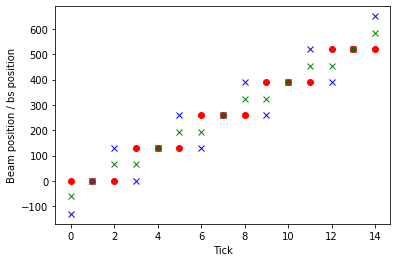

In [ ]:
## beamspot location 
true_beamspot_positions = ( 
        true_B1_positions/params["Sigma_B1"]**2 + 
        true_B2_positions/params["Sigma_B2"]**2
    )/(params["Sigma_B1"]**-2+params["Sigma_B2"]**-2)


plt.plot(range(15), nominal_B1_positions, "or")
plt.plot(range(15), nominal_B2_positions, "xb")
plt.plot(range(15), true_beamspot_positions, "xg")
plt.xlabel('Tick')
plt.ylabel('Beam position / bs position')

In [ ]:
## rates
true_rates     = np.exp(-0.5 * (true_B1_positions-true_B2_positions)**2 / (params["Sigma_B1"]**2+params["Sigma_B2"]**2) )
true_rates_unc = true_rates**0.5 * np.max(true_rates)**0.5 * params["rate_runcertainty_at_head_on"]

In [ ]:
## calculate head-on beamspot position

def get_headon_position(rates, rate_unc, separations, beamspot_positions ):

    def sg(x,a,m,s):
        return a*np.exp(-0.5*((x-m)/s)**2)
    
    a0 = np.max(rates)
    m0 = separations[1]
    s0 = np.abs(separations[1] - separations[0])
    popt_sg, pcov_sg = curve_fit(sg, separations, rates, sigma=rate_unc, 
                                    p0=[a0, m0, s0 ],
                                    p0_lim = [
                                        [a0/2, a0*2],
                                        [m0-s0, m0+s0],
                                        [s0/2, s0*2],
                                    ] )

    mu               = popt_sg[1]

    def lin(x,a,b):
        return a*x+b

    popt_lin, pcov_lin = curve_fit(lin, separations, beamspot_positions, sigma=[params["beamspot_position_uncertainty"]]*3, p0=[1, 0])
    a = popt_lin[0]
    b = popt_lin[1]

    # compute result uncertainty
    if np.allclose(pcov_lin, 0):
        std = a*pcov_sg[1,1]**0.5
    else:
        mu_randomized = mu + pcov_sg[1,1]**0.5*np.random.normal(size=1000)
        try:
            pcov_lin_sqrt = np.linalg.cholesky(pcov_lin)
        except Exception as e:
            print(e)
            print(pcov_lin)
            sys.exit()

        ab_randomized = popt_lin[:,np.newaxis] + np.einsum("ij,jk", pcov_lin_sqrt, np.random.normal(size=(2,1000)))
        std = np.std( ab_randomized[0,:]*mu_randomized + ab_randomized[1,:] )

    if std == 0:
        std = 1e-6

    return a*mu+b, std


computed_head_on_bs_position = []
computed_head_on_bs_position_unc = []
for i in range(5):

    v, u = get_headon_position(
        true_rates[3*i:3*i+3],
        true_rates_unc[3*i:3*i+3],
        # analysis_B1_positions[3*i:3*i+3] - analysis_B2_positions[3*i:3*i+3],
        analysis_separations[3*i:3*i+3],
        true_beamspot_positions[3*i:3*i+3])
    computed_head_on_bs_position.append(v) 
    computed_head_on_bs_position_unc.append(u)

print(computed_head_on_bs_position)
print(computed_head_on_bs_position_unc)

[3.3551750108570704, 129.99999999999446, 260.0000000000134, 390.00000000003223, 519.9999999997934]
[0.6572720938350313, 0.6656388730233125, 0.6504223501750708, 0.6638092741253706, 0.632405765442528]


computed LSC 0.9949669139290197 +/- 0.0015777136728873094


Text(0, 0.5, 'Beamspot position - X values')

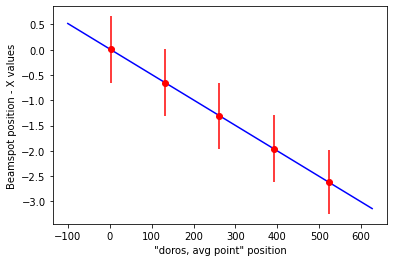

In [ ]:
def lin(x,a,b):
        return a*x+b

a0 = (computed_head_on_bs_position_unc[-1]-computed_head_on_bs_position_unc[0])/(analysis_B1_5positions[-1]-analysis_B1_5positions[0])
b0 = 0
popt_lin, pcov_lin = curve_fit(lin, analysis_B1_5positions, computed_head_on_bs_position, sigma=computed_head_on_bs_position_unc, p0=[a0, b0])
a = popt_lin[0]
b = popt_lin[1]

print("computed LSC", a, "+/-", pcov_lin[0,0]**0.5)

liml = np.min(analysis_B1_5positions) - 0.2 * (np.max(analysis_B1_5positions)-np.min(analysis_B1_5positions))
limu = np.max(analysis_B1_5positions) + 0.2 * (np.max(analysis_B1_5positions)-np.min(analysis_B1_5positions))
x = np.linspace(liml, limu, 2)
plt.plot(x, lin(x,a-1,b), "b-")
plt.errorbar(analysis_B1_5positions, computed_head_on_bs_position - analysis_B1_5positions, yerr=computed_head_on_bs_position_unc, fmt="or")


plt.xlabel('"'+params["pos_strategy"] + '" position')
plt.ylabel('Beamspot position - X values')